# Bonificación Práctica 1

## Introducción 

En este JBook se desarrolla el ejercicio propuesto sobre metodos de **_Suavización Exponencial_**

Dentro de los metodos trabajados se encuentran:

* Suavización exponencial de primer orden
* Suavización exponencial de segundo orden
* Suavización exponencial con factor de descuento
* Holt Winters

## Acerca de los datos

```{admonition} Dataset Propuesto
:class: tip
El dataset propuesto para la presente práctica consiste en mediciones de la potencia eléctrica correspondientes a una señal de control de entrada a lo largo del tiempo, recopiladas de una microturbina de gas comercial de 3 kilovatios

Este Dataset fue usado en el siguiente articulo: [Knowledge-Guided Learning of Temporal Dynamics and its
Application to Gas Turbines](https://dl.acm.org/doi/fullHtml/10.1145/3632775.3661967)
```
```{admonition} **Información Adicional:**
:class: tip
El conjunto de datos incluye ocho series de tiempo que describen el comportamiento de la
microturbina de gas bajo diversas condiciones. Cada serie representa un experimento separado
donde se varió la señal de control de entrada a lo largo del tiempo y se midió la potencia eléctrica
de salida resultante. Las series de tiempo varían en duración desde 6,495 hasta 11,820 puntos de
datos con una resolución de aproximadamente 1 segundo, lo que corresponde a aproximadamente
1.8 a 3.3 horas. Cada nivel de la señal de control de entrada corresponde a un nivel estacionario, es
decir, constante, de la potencia de salida. Cabe destacar que se observa un retraso notable en la
señal de salida durante las transiciones en respuesta a cambios en la señal de control de entrada.
```

```{admonition} Tabla de Variables

| Nombre de la Variable | Rol          | Tipo     | Descripción                    | Unidades | Valores Faltantes |
|-----------------------|--------------|----------|--------------------------------|----------|-------------------|
| time                  | ID           | Continuo | Tiempo                         | segundos | no                |
| input_voltage          | Característica | Continuo | Voltaje de control de entrada  | voltios  | no                |
| el_power               | Objetivo     | Continuo | Potencia de salida eléctrica   | vatios   | no                |




Según la información del dataset, tenemos 8 series de tiempo que describen un mismo fenómeno, en este caso la potencia eléctrica de salida al variar la señal de control en el tiempo.

Para este caso la medicion se realizó en segundos.

Con esta información, al tratarse de series temporales diferentes lo más conveniente es estudiar su comportamiento por separado (esto para el conjunto de entrenamiento) y luego probarlas sobre el conjunto de prueba para validar las métricas de ajuste de los diferentes modelos.

## Implementación

### Importación de librerias necesarias

In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa import seasonal
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from functions import Functions #Personalized module of functions


In [2]:
import warnings
warnings.filterwarnings("ignore")
FT = Functions() # Instantiate the class.

### EDA conjunto de entrenamiento

Primero procedemos a calcular las estadísticas básicas de cada uno de los datasets, para esto se hace uso de una clase previamente importada que contiene funciones predefinidas para estos cálculos básicos:

In [3]:
train1 = pd.read_csv("../Datasets/EjerciciosPracticos/train/ex_1.csv")
FT.BasicStatisticsDataFrame(train1)

📊📊📊📊📊Dataset Head📊📊📊📊📊
        time  input_voltage     el_power
0  810.07028             10  1228.791720
1  811.06938             10  1223.041745
2  812.06848             10  1244.960866
3  813.06758             10  1229.259058
4  814.06668             10  1248.117024


📊📊📊📊📊Dataset Shape📊📊📊📊📊
(9920, 3)


📊📊📊📊📊Dataset information📊📊📊📊📊
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9920 entries, 0 to 9919
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           9920 non-null   float64
 1   input_voltage  9920 non-null   int64  
 2   el_power       9920 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 232.6 KB


📊📊📊📊📊Descriptive statistics📊📊📊📊📊
               time  input_voltage     el_power
count   9920.000000    9920.000000  9920.000000
mean    5765.317878       6.822480  2162.427874
std     2861.440154       3.485288  1009.468755
min      810.070280       3.000000   932.837260
25%     32

Este primer conjunto de datos no presenta valores nulos, además de entre todos los conjuntos de entrenamiento es el que mayor media, desviación estandar y valor máximo presenta

In [4]:
def line_plot(df):
    plt.figure(figsize=(10,6))
    sns.lineplot(x='time', y='el_power', data=df)
    plt.title('Power variability over time')
    plt.xlabel('time')
    plt.ylabel('el_power')
    plt.show()

def plot_hist(df, col):
    plt.figure(figsize=(10,6))
    sns.histplot(df[col], bins=20, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

def plot_box(df, col):
    plt.figure(figsize=(10,6))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

def Caculate_ADF(df, col):
    result = adfuller(df[col])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

def plot_descomposition(df, col, period, model="additive"):
    df = df.sort_values(by="time")
    decomposition = seasonal_decompose(df[col], period=period, model=model)
    decomposition.plot()
    plt.show()

def calculate_period(df):
    fft = np.fft.fft(df)
    frequencies = np.fft.fftfreq(len(df))
    positive_frequencies = frequencies[np.where(frequencies > 0)]
    magnitudes = abs(fft[np.where(frequencies > 0)])
    peak_frequency = positive_frequencies[np.argmax(magnitudes)]
    period = 1 / peak_frequency
    return int(round(period))




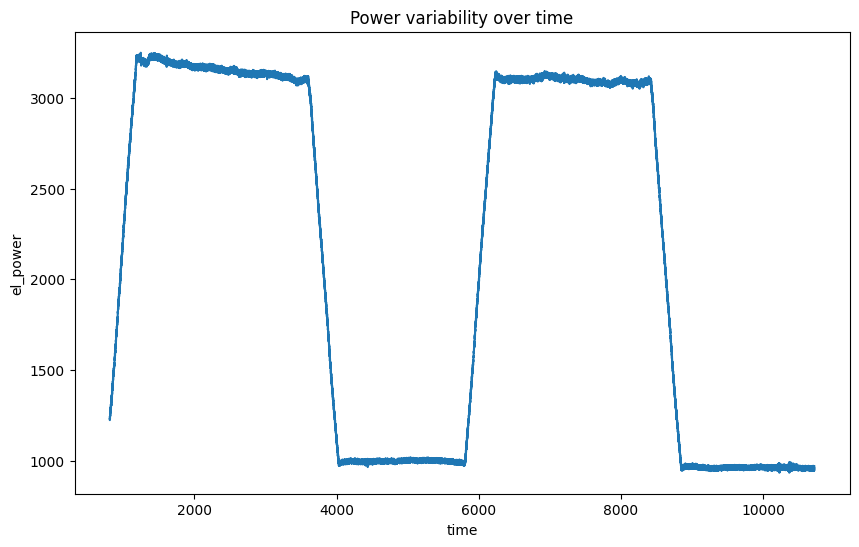

In [5]:
line_plot(train1)

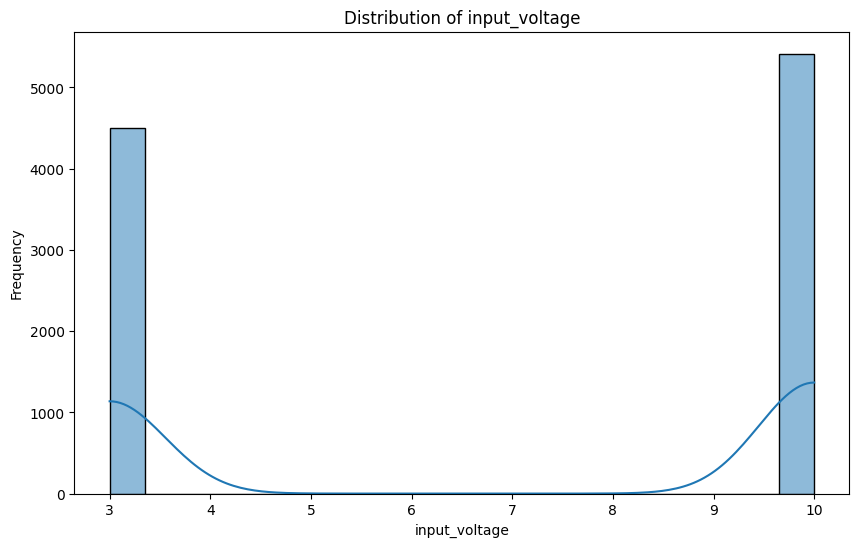

In [6]:
plot_hist(train1, "input_voltage")

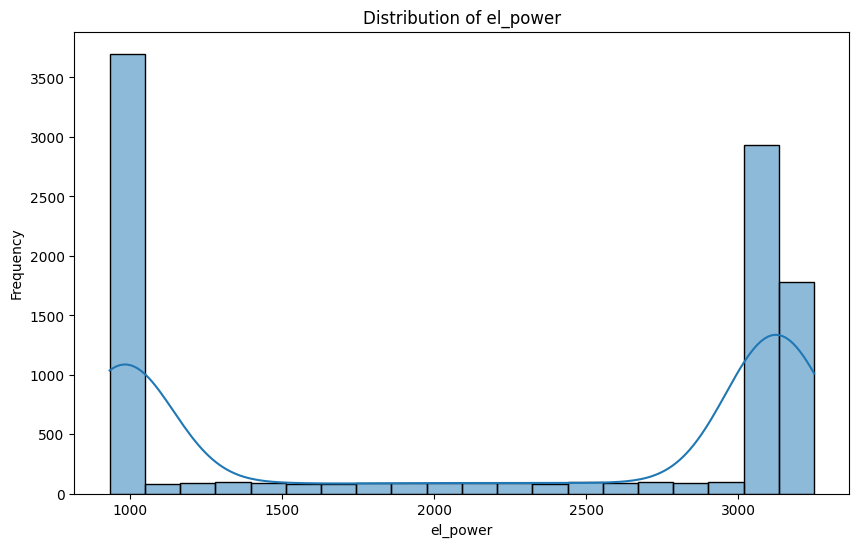

In [7]:
plot_hist(train1, "el_power")


In [8]:
period = calculate_period(train1['el_power'])
period

4960

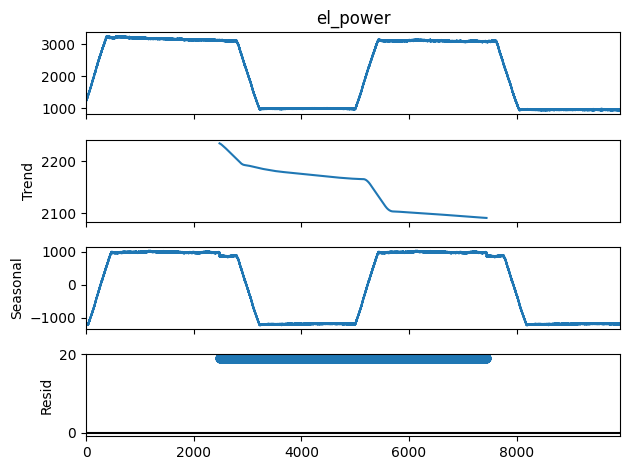

In [9]:
plot_descomposition(train1, "el_power", period)

<Figure size 550x550 with 0 Axes>

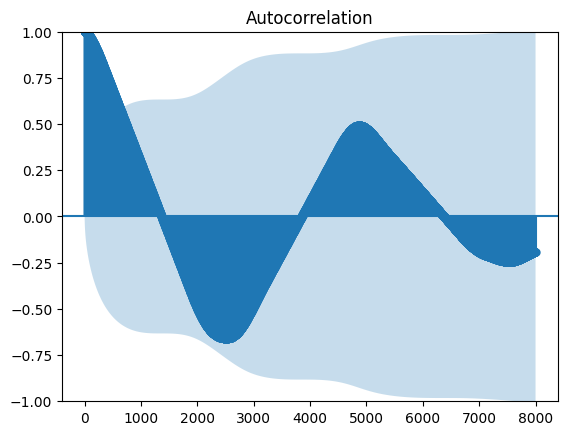

In [10]:
plt.figure(figsize=(5.5, 5.5));
plot_acf(train1['el_power'], lags=8000);

In [11]:
Caculate_ADF(train1, "el_power")

ADF Statistic: -2.880034779003427
p-value: 0.047719427772114374
Critical Values:
   1%, -3.4310119774951406
Critical Values:
   5%, -2.861832554286939
Critical Values:
   10%, -2.566925721514317


In [11]:
first_order_diff = train1['el_power'].diff(1)

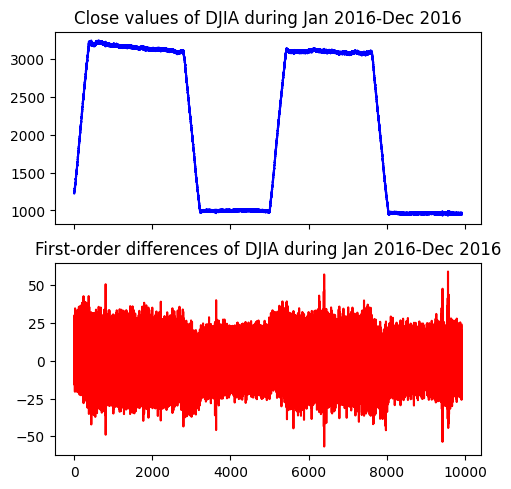

In [12]:
fig, ax = plt.subplots(2, sharex=True)
fig.set_size_inches(5.5, 5.5)
train1['el_power'].plot(ax=ax[0], color='b');
ax[0].set_title('Close values of DJIA during Jan 2016-Dec 2016');
first_order_diff.plot(ax=ax[1], color='r');
ax[1].set_title('First-order differences of DJIA during Jan 2016-Dec 2016');

In [14]:
seasonal_diff = train1.diff(4960)
seasonal_diff = seasonal_diff[4960:]

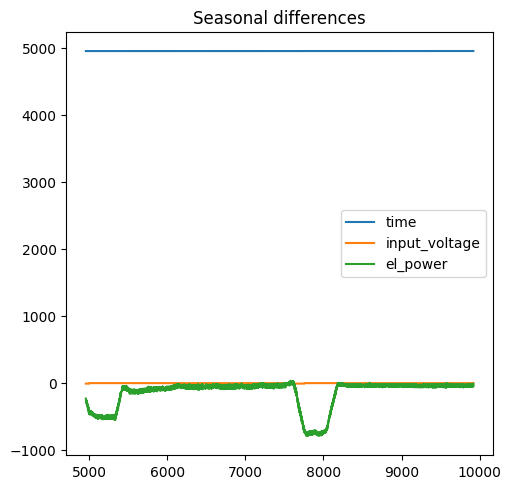

In [15]:
fig = plt.figure(figsize=(5.5, 5.5))
ax = fig.add_subplot(1,1,1)
ax.set_title('Seasonal differences');
seasonal_diff.plot(ax=ax);

In [13]:
train9 = pd.read_csv("../Datasets/EjerciciosPracticos/train/ex_9.csv")
FT.BasicStatisticsDataFrame(train9)

📊📊📊📊📊Dataset Head📊📊📊📊📊
     time  input_voltage     el_power
0  818.84          3.445  1253.790314
1  819.84          3.445  1349.836854
2  820.84          3.445  1262.033813
3  821.84          3.445  1370.205819
4  822.84          3.445  1254.782490


📊📊📊📊📊Dataset Shape📊📊📊📊📊
(11819, 3)


📊📊📊📊📊Dataset information📊📊📊📊📊
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11819 entries, 0 to 11818
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           11819 non-null  float64
 1   input_voltage  11819 non-null  float64
 2   el_power       11819 non-null  float64
dtypes: float64(3)
memory usage: 277.1 KB


📊📊📊📊📊Descriptive statistics📊📊📊📊📊
              time  input_voltage      el_power
count  11819.00000   11819.000000  11819.000000
mean    6727.84000       5.538021   1828.548454
std     3411.99575       1.397095    402.170208
min      818.84000       3.445000   1204.205671
25%     3773.34000       4.305000  

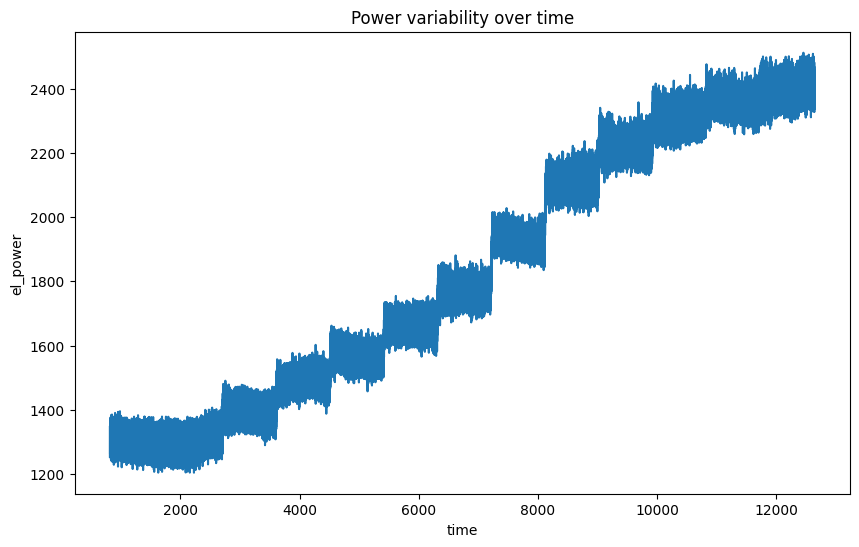

In [14]:
line_plot(train9)

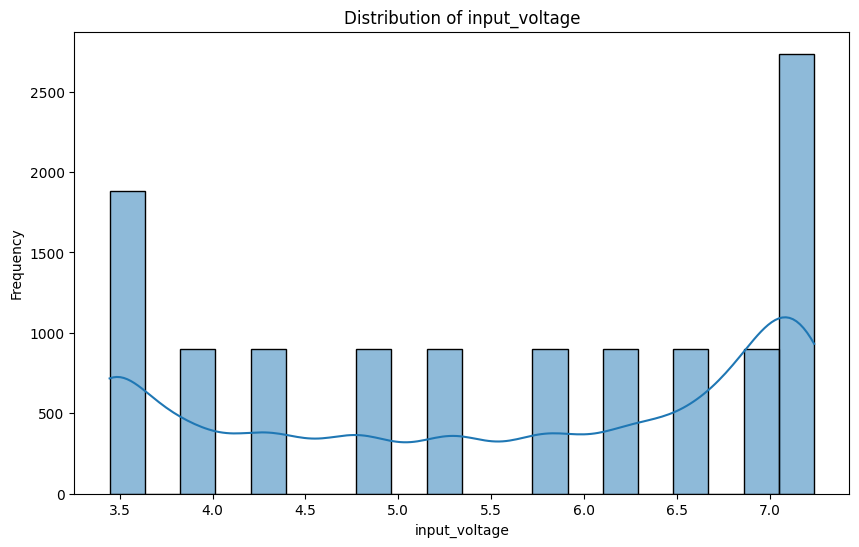

In [15]:
plot_hist(train9, "input_voltage")

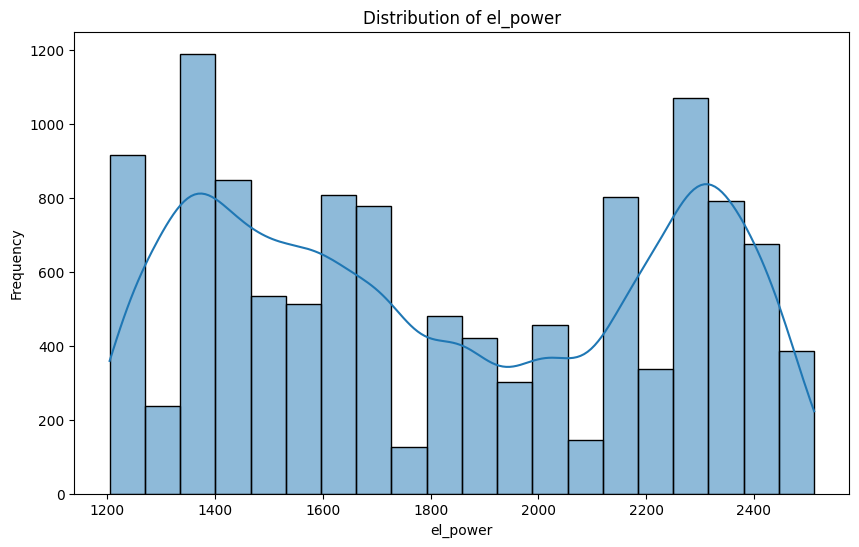

In [16]:
plot_hist(train9, "el_power")

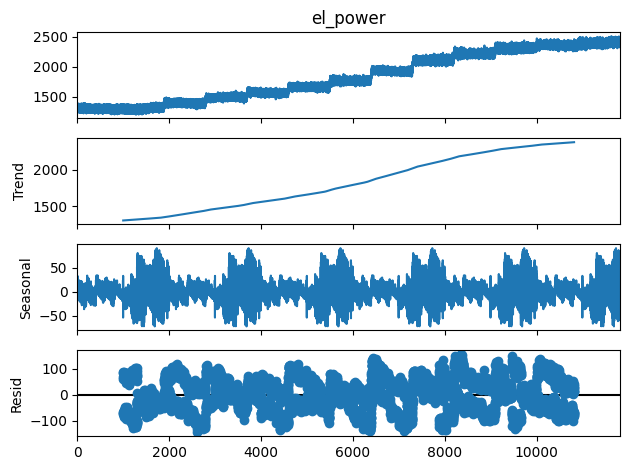

In [17]:
plot_descomposition(train9, "el_power", 2000)


In [18]:
Caculate_ADF(train9, "el_power")

ADF Statistic: -0.2662656661214094
p-value: 0.9301480968227475
Critical Values:
   1%, -3.430905051344695
Critical Values:
   5%, -2.861785303766895
Critical Values:
   10%, -2.5669005701267875


<Figure size 550x550 with 0 Axes>

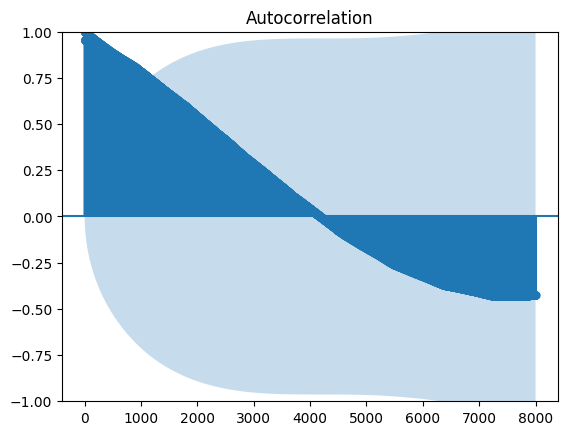

In [19]:
plt.figure(figsize=(5.5, 5.5));
plot_acf(train9['el_power'], lags=8000);

In [20]:
train20 = pd.read_csv("../Datasets/EjerciciosPracticos/train/ex_20.csv")
FT.BasicStatisticsDataFrame(train20)

📊📊📊📊📊Dataset Head📊📊📊📊📊
     time  input_voltage     el_power
0  849.22            3.0  1238.511285
1  850.24            3.0  1149.563728
2  851.26            3.0  1226.959165
3  852.28            3.0  1158.086961
4  853.30            3.0  1230.435294


📊📊📊📊📊Dataset Shape📊📊📊📊📊
(6495, 3)


📊📊📊📊📊Dataset information📊📊📊📊📊
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6495 entries, 0 to 6494
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           6495 non-null   float64
 1   input_voltage  6495 non-null   float64
 2   el_power       6495 non-null   float64
dtypes: float64(3)
memory usage: 152.4 KB


📊📊📊📊📊Descriptive statistics📊📊📊📊📊
              time  input_voltage     el_power
count  6495.000000    6495.000000  6495.000000
mean   4285.243504       4.655119  1623.263494
std    2015.543637       2.481296   632.985147
min     849.220000       3.000000  1097.030791
25%    2534.680000       3.000000  1158.548

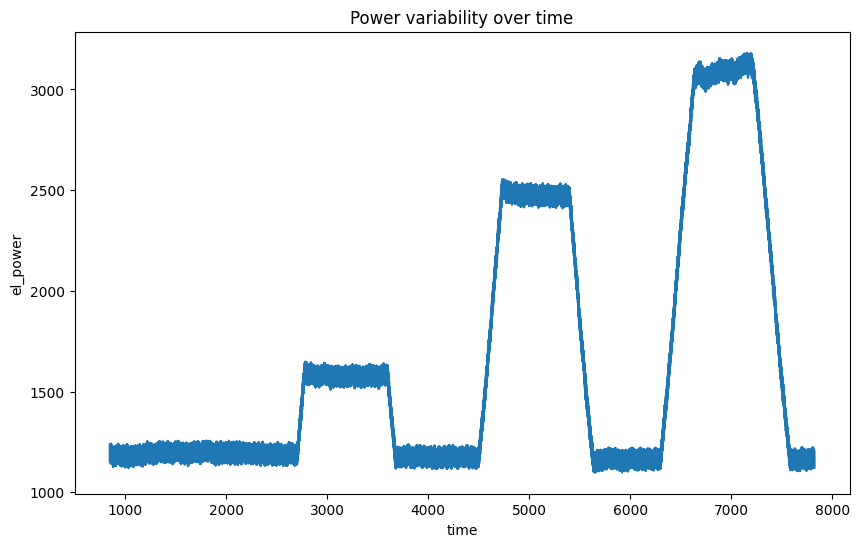

In [21]:
line_plot(train20)

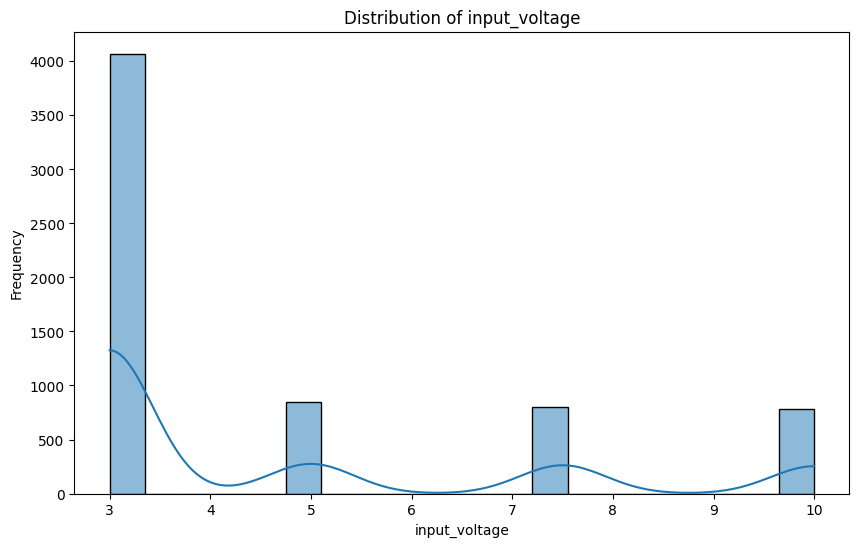

In [22]:
plot_hist(train20, "input_voltage")

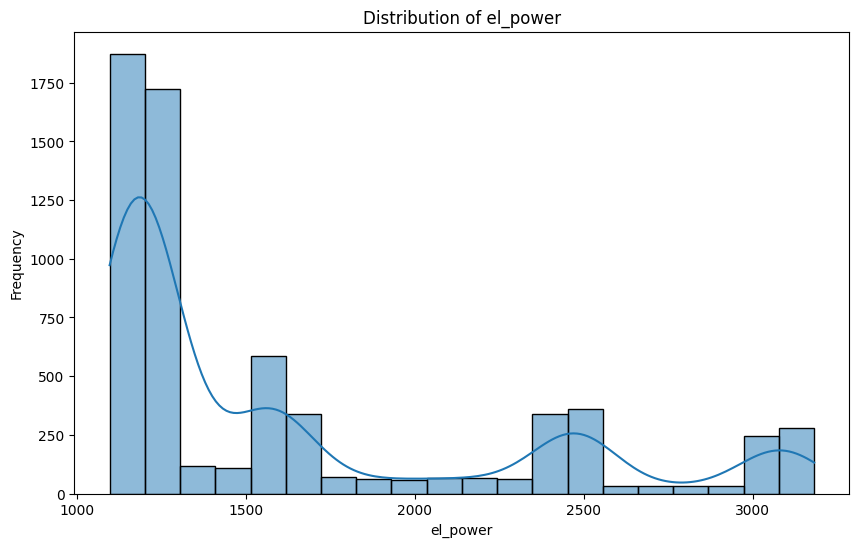

In [23]:
plot_hist(train20, "el_power")

In [24]:
Caculate_ADF(train20, "el_power")

ADF Statistic: -3.391959550174136
p-value: 0.011236042963495362
Critical Values:
   1%, -3.431362678073597
Critical Values:
   5%, -2.861987516467093
Critical Values:
   10%, -2.567008209725963


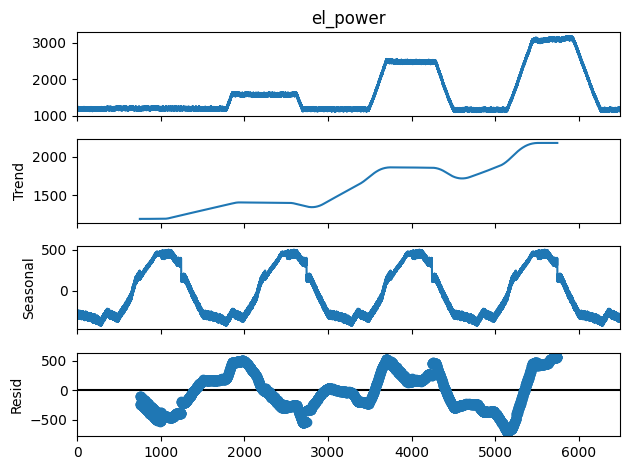

In [25]:
plot_descomposition(train20, "el_power", 1500)

<Figure size 550x550 with 0 Axes>

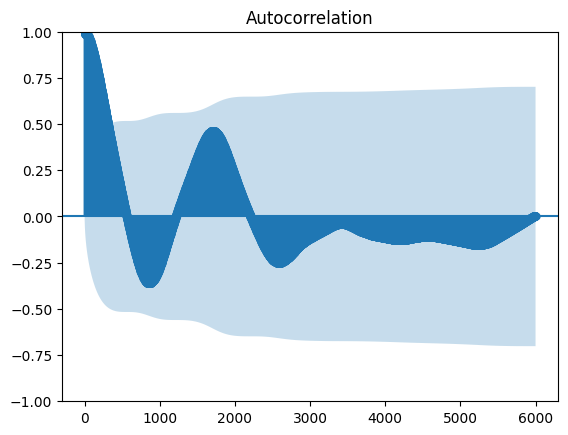

In [26]:
plt.figure(figsize=(5.5, 5.5));
plot_acf(train20['el_power'], lags=6000);

In [27]:
train21 = pd.read_csv("../Datasets/EjerciciosPracticos/train/ex_21.csv")
FT.BasicStatisticsDataFrame(train21)

📊📊📊📊📊Dataset Head📊📊📊📊📊
     time  input_voltage     el_power
0  847.72            3.0  1089.895066
1  848.74            3.0  1179.843179
2  849.78            3.0  1099.497553
3  850.80            3.0  1181.551142
4  851.82            3.0  1100.823819


📊📊📊📊📊Dataset Shape📊📊📊📊📊
(6495, 3)


📊📊📊📊📊Dataset information📊📊📊📊📊
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6495 entries, 0 to 6494
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           6495 non-null   float64
 1   input_voltage  6495 non-null   float64
 2   el_power       6495 non-null   float64
dtypes: float64(3)
memory usage: 152.4 KB


📊📊📊📊📊Descriptive statistics📊📊📊📊📊
              time  input_voltage     el_power
count  6495.000000    6495.000000  6495.000000
mean   4252.303279       4.658276  1576.460277
std    1999.890706       2.479646   638.042444
min     847.720000       3.000000  1045.541020
25%    2513.030000       3.000000  1112.552

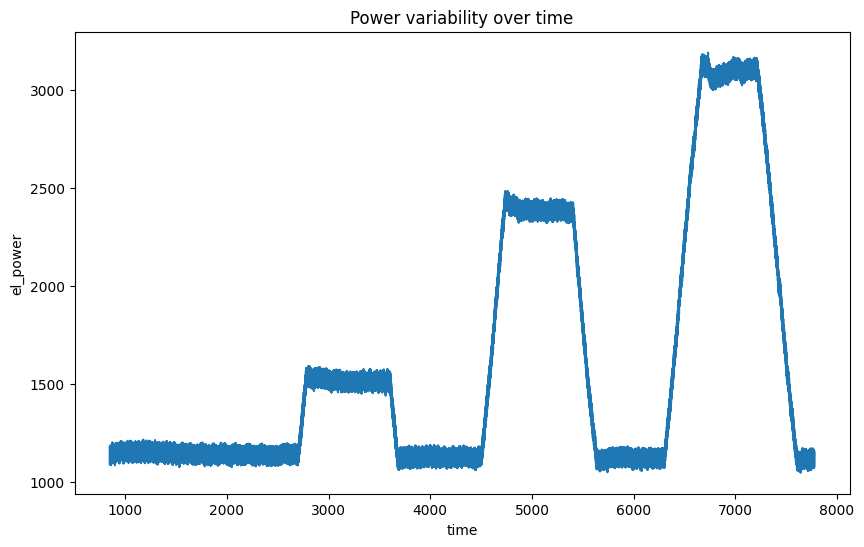

In [28]:
line_plot(train21)

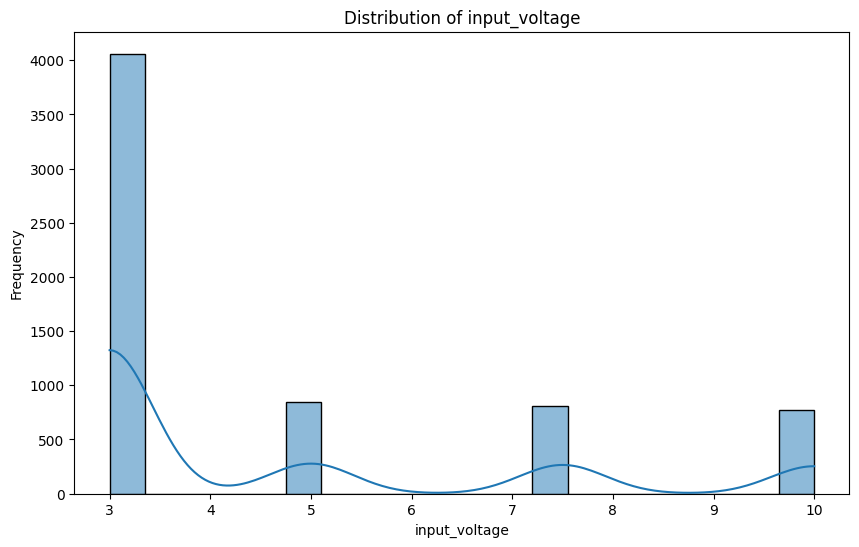

In [29]:
plot_hist(train21, "input_voltage")

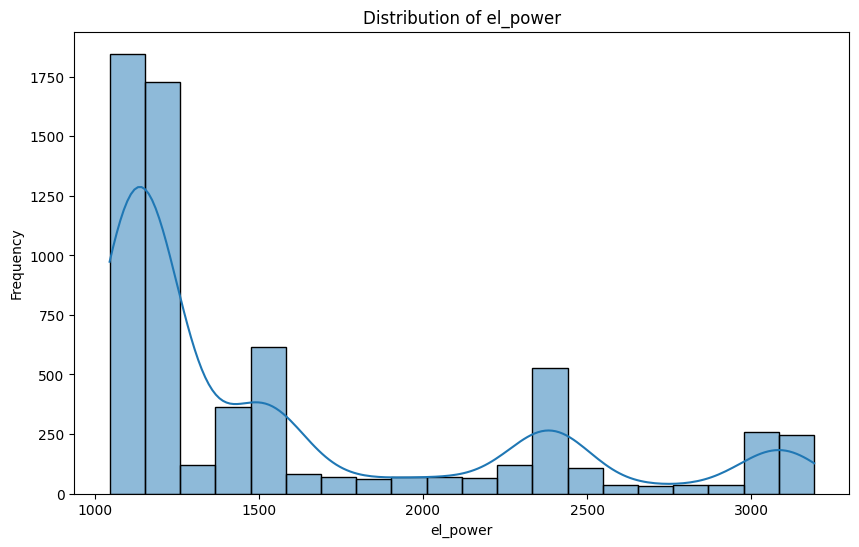

In [30]:
plot_hist(train21, "el_power")

In [31]:
Caculate_ADF(train21, "el_power")

ADF Statistic: -3.4516264318605643
p-value: 0.009319892749348871
Critical Values:
   1%, -3.4313628349215555
Critical Values:
   5%, -2.86198758576857
Critical Values:
   10%, -2.5670082466166657


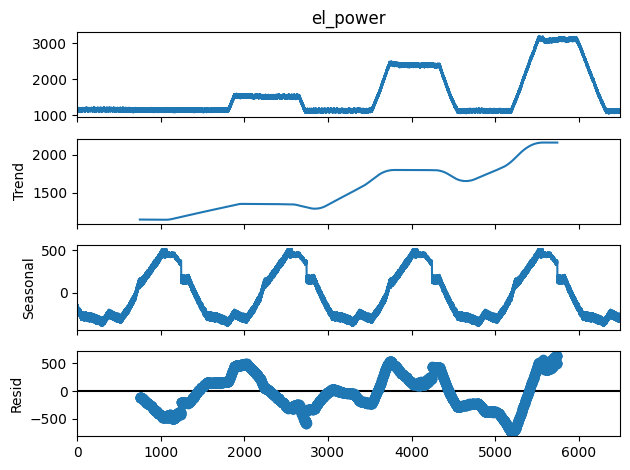

In [32]:
plot_descomposition(train21, "el_power", 1500)

<Figure size 550x550 with 0 Axes>

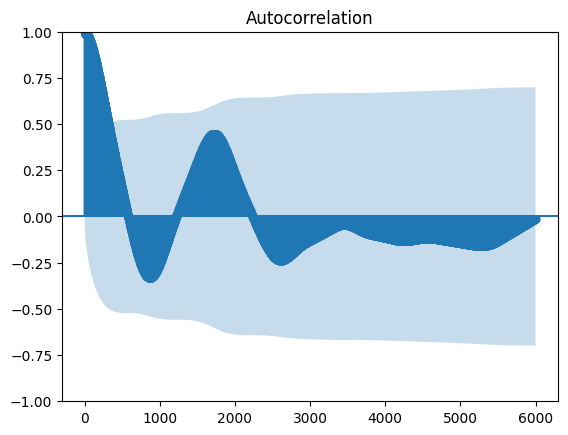

In [33]:
plt.figure(figsize=(5.5, 5.5));
plot_acf(train21['el_power'], lags=6000);

In [34]:
train23 = pd.read_csv("../Datasets/EjerciciosPracticos/train/ex_23.csv")
FT.BasicStatisticsDataFrame(train23)

📊📊📊📊📊Dataset Head📊📊📊📊📊
     time  input_voltage     el_power
0  810.00            3.0  1102.949693
1  811.04            3.0  1199.403786
2  812.08            3.0  1113.199817
3  813.18            3.0  1200.377939
4  814.18            3.0  1105.465349


📊📊📊📊📊Dataset Shape📊📊📊📊📊
(9188, 3)


📊📊📊📊📊Dataset information📊📊📊📊📊
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9188 entries, 0 to 9187
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           9188 non-null   float64
 1   input_voltage  9188 non-null   float64
 2   el_power       9188 non-null   float64
dtypes: float64(3)
memory usage: 215.5 KB


📊📊📊📊📊Descriptive statistics📊📊📊📊📊
               time  input_voltage     el_power
count   9188.000000    9188.000000  9188.000000
mean    5821.804822       5.258644  1899.231847
std     2964.155040       2.235487   693.044107
min      810.000000       3.000000  1053.218306
25%     3205.085000       3.000000  12

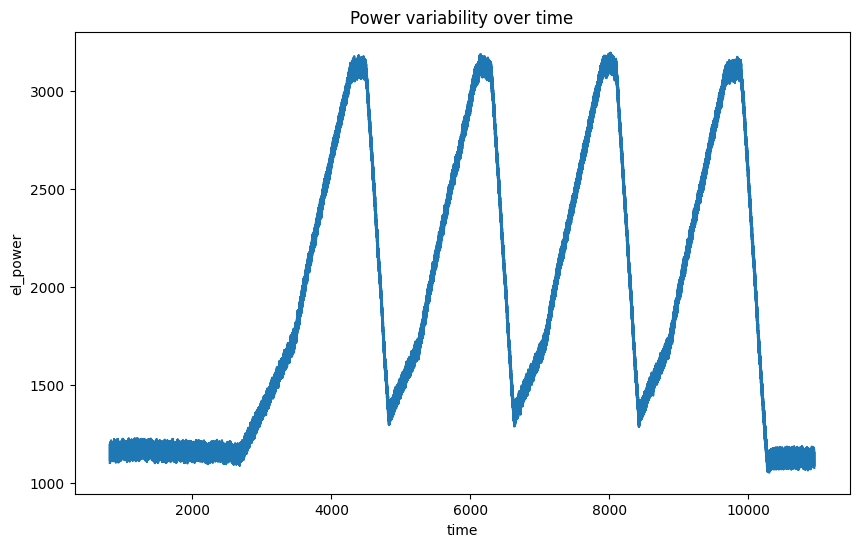

In [35]:
line_plot(train23)

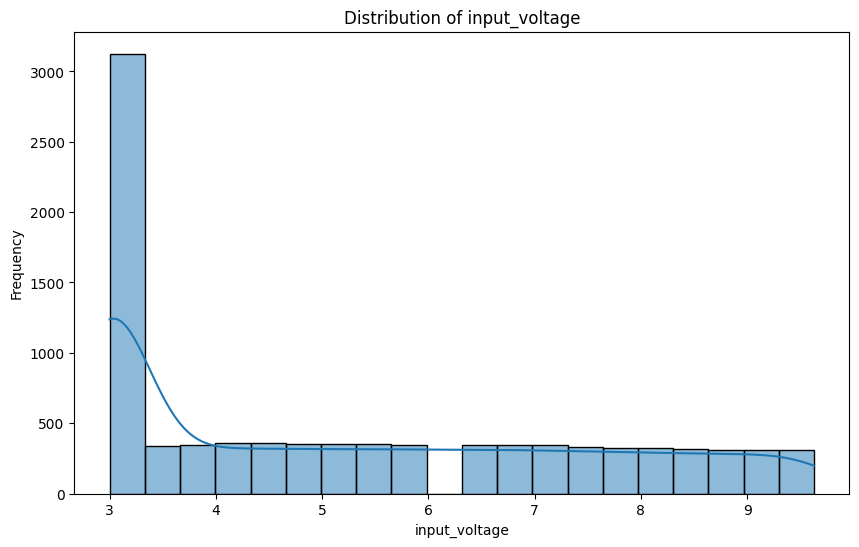

In [36]:
plot_hist(train23, "input_voltage")

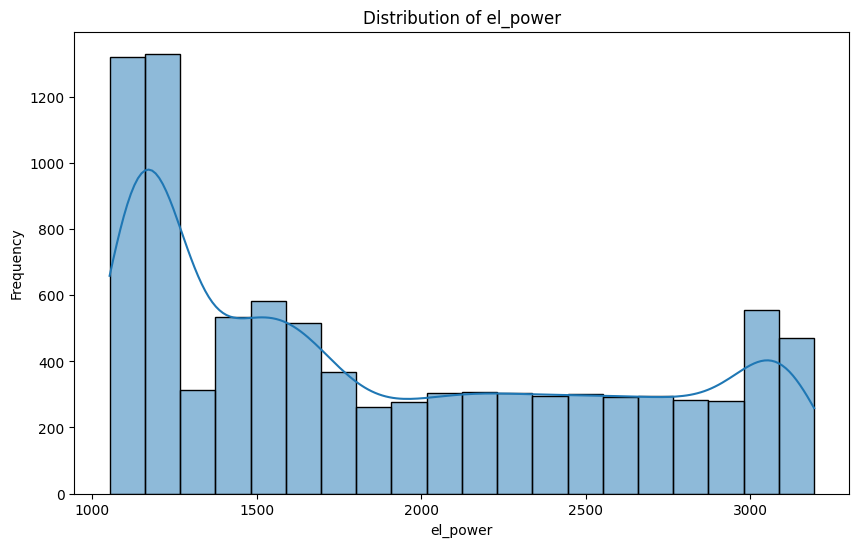

In [37]:
plot_hist(train23, "el_power")

In [38]:
Caculate_ADF(train23, "el_power")

ADF Statistic: -4.266145547661307
p-value: 0.0005081533115464868
Critical Values:
   1%, -3.431064956354247
Critical Values:
   5%, -2.8618559649427446
Critical Values:
   10%, -2.5669381830831886


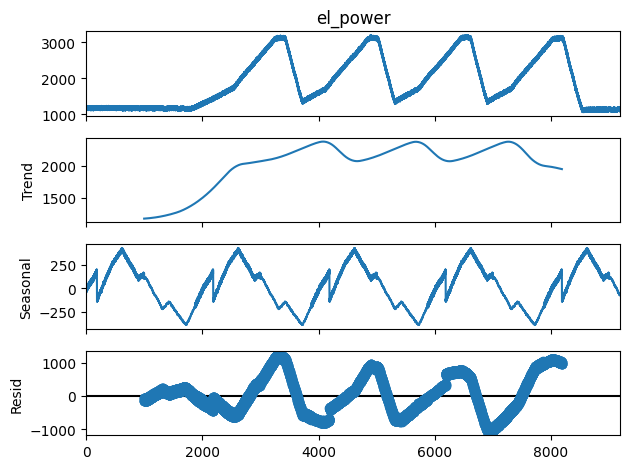

In [39]:
plot_descomposition(train23, "el_power", 2000)

<Figure size 550x550 with 0 Axes>

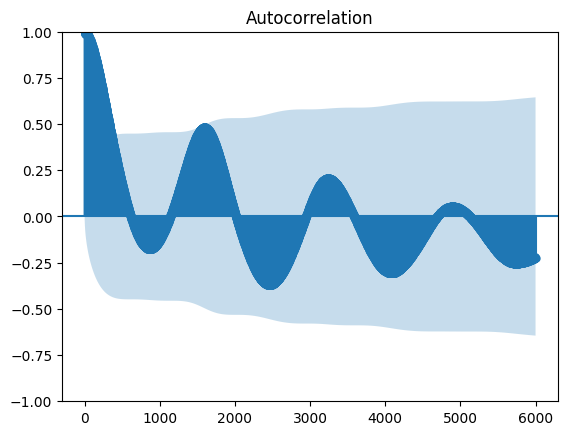

In [40]:
plt.figure(figsize=(5.5, 5.5));
plot_acf(train23['el_power'], lags=6000);

In [41]:
train24 = pd.read_csv("../Datasets/EjerciciosPracticos/train/ex_24.csv")
FT.BasicStatisticsDataFrame(train24)

📊📊📊📊📊Dataset Head📊📊📊📊📊
     time  input_voltage     el_power
0  811.04            3.0  1217.413110
1  812.04            3.0  1140.090013
2  813.06            3.0  1223.751987
3  814.10            3.0  1124.810110
4  815.12            3.0  1207.671543


📊📊📊📊📊Dataset Shape📊📊📊📊📊
(9023, 3)


📊📊📊📊📊Dataset information📊📊📊📊📊
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9023 entries, 0 to 9022
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           9023 non-null   float64
 1   input_voltage  9023 non-null   float64
 2   el_power       9023 non-null   float64
dtypes: float64(3)
memory usage: 211.6 KB


📊📊📊📊📊Descriptive statistics📊📊📊📊📊
               time  input_voltage     el_power
count   9023.000000    9023.000000  9023.000000
mean    5669.373056       5.488547  1805.375104
std     2849.219820       2.297978   680.139456
min      811.040000       3.000000  1054.175250
25%     3161.990000       3.000000  12

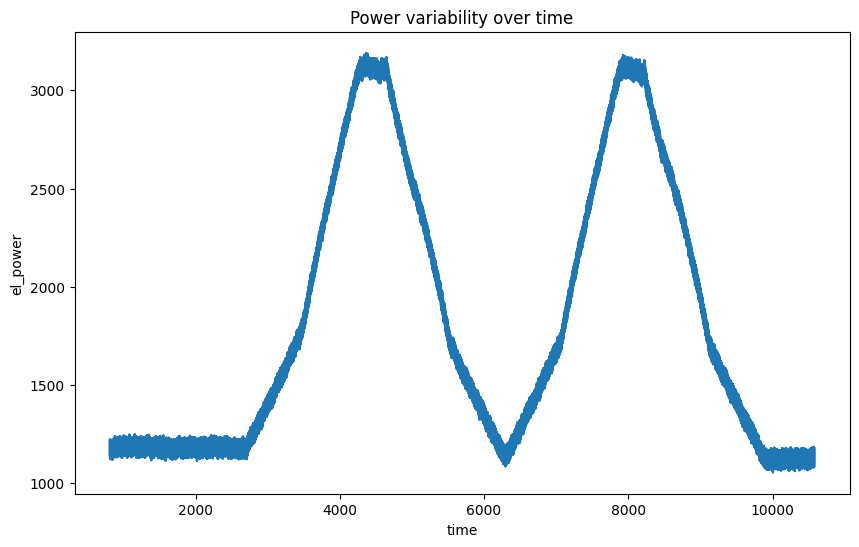

In [42]:
line_plot(train24)

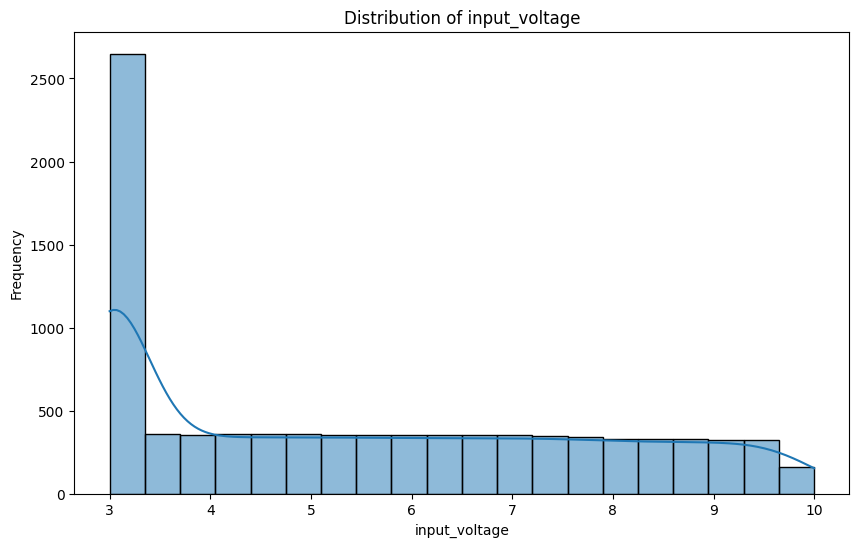

In [43]:
plot_hist(train24, "input_voltage")

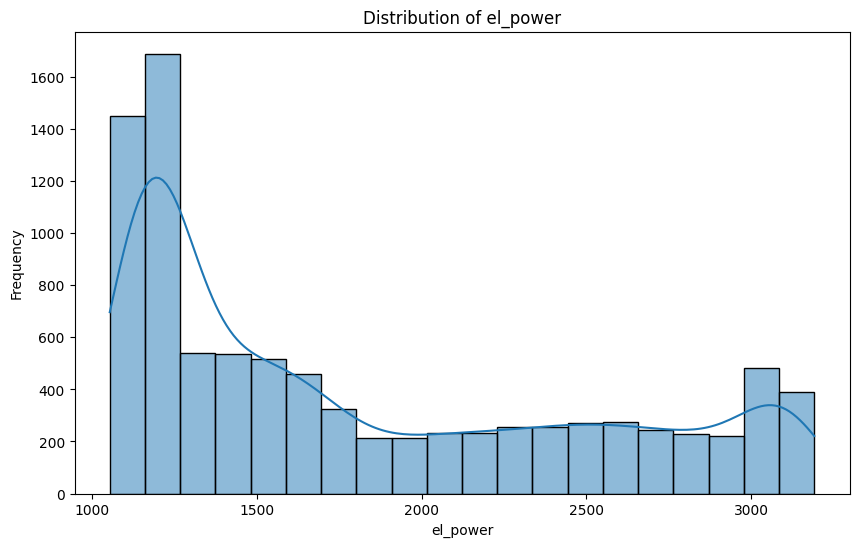

In [44]:
plot_hist(train24, "el_power")

In [45]:
Caculate_ADF(train24, "el_power")

ADF Statistic: -1.33738182952345
p-value: 0.6119013728890791
Critical Values:
   1%, -3.431077928889453
Critical Values:
   5%, -2.8618616972705597
Critical Values:
   10%, -2.566941234431045


### Estadísticas básicas conjunto de prueba

In [46]:
test4 = pd.read_csv("../Datasets/EjerciciosPracticos/test/ex_4.csv")
FT.BasicStatisticsDataFrame(test4)

📊📊📊📊📊Dataset Head📊📊📊📊📊
         time  input_voltage     el_power
0  758.425813            3.0  1206.993434
1  759.425109            3.0  1255.072122
2  760.424406            3.0  1203.093254
3  761.423702            3.0  1259.000662
4  762.422998            3.0  1196.033782


📊📊📊📊📊Dataset Shape📊📊📊📊📊
(9795, 3)


📊📊📊📊📊Dataset information📊📊📊📊📊
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9795 entries, 0 to 9794
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           9795 non-null   float64
 1   input_voltage  9795 non-null   float64
 2   el_power       9795 non-null   float64
dtypes: float64(3)
memory usage: 229.7 KB


📊📊📊📊📊Descriptive statistics📊📊📊📊📊
               time  input_voltage     el_power
count   9795.000000    9795.000000  9795.000000
mean    5651.979106       5.548392  1938.575453
std     2825.727015       2.948274   819.978754
min      758.425813       3.000000  1109.522853
25%     3205.2

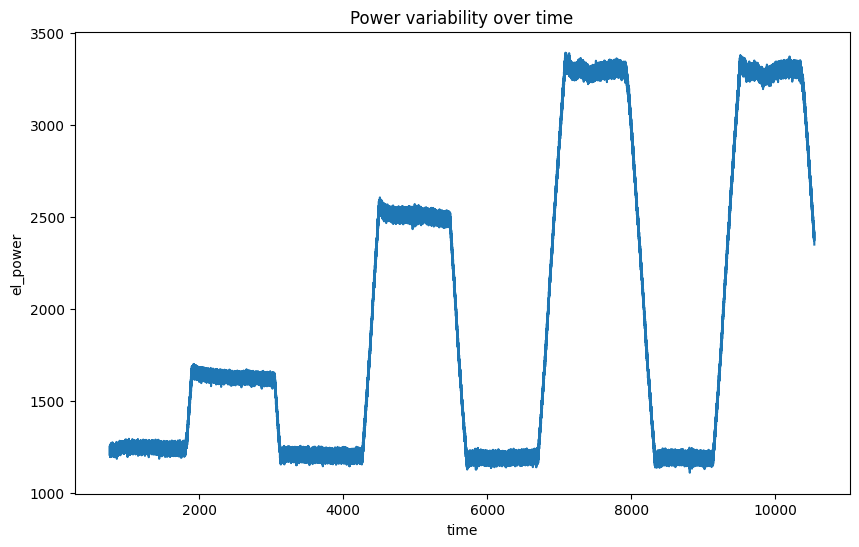

In [47]:
line_plot(test4)

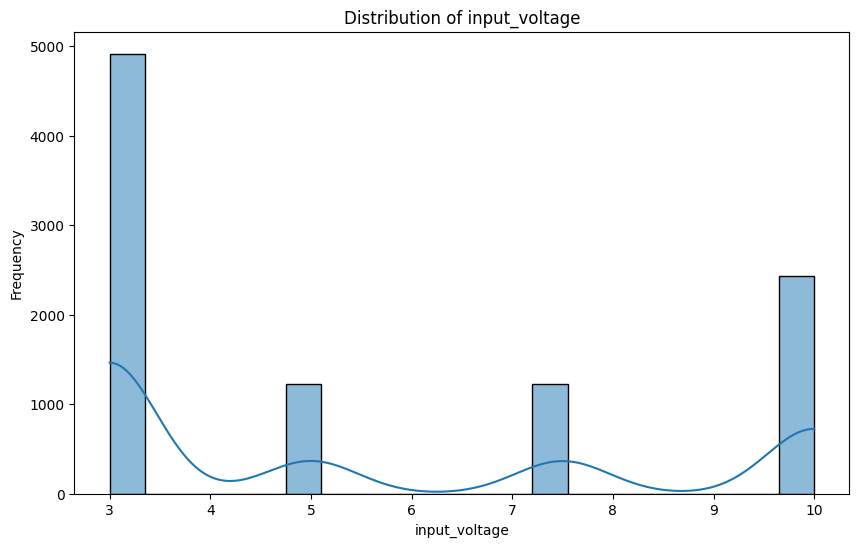

In [48]:
plot_hist(test4, "input_voltage")

In [49]:
Caculate_ADF(test4, "el_power")

ADF Statistic: -3.9075063089209308
p-value: 0.001980294064980506
Critical Values:
   1%, -3.4310204613998323
Critical Values:
   5%, -2.8618363032400596
Critical Values:
   10%, -2.566927717089522


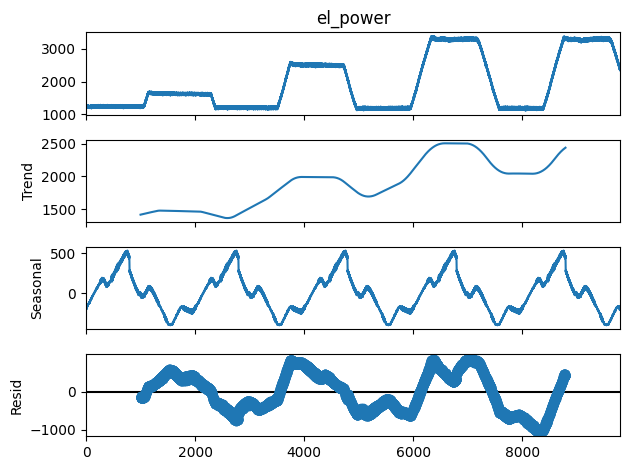

In [50]:
plot_descomposition(test4, "el_power", 2000)

<Figure size 550x550 with 0 Axes>

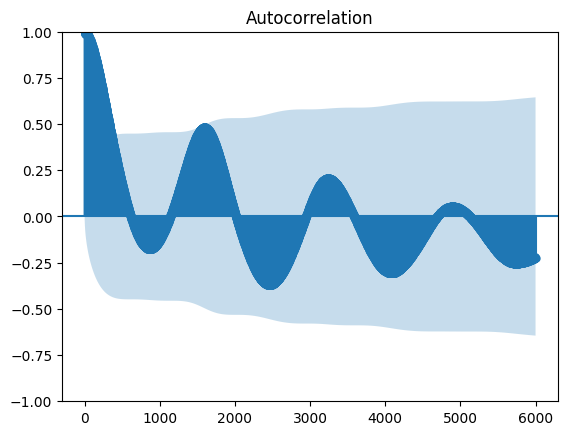

In [51]:
plt.figure(figsize=(5.5, 5.5));
plot_acf(train23['el_power'], lags=6000);

In [52]:
test22 = pd.read_csv("../Datasets/EjerciciosPracticos/test/ex_22.csv")
FT.BasicStatisticsDataFrame(test22)

📊📊📊📊📊Dataset Head📊📊📊📊📊
    time  input_voltage     el_power
0  880.3            3.0  1193.140713
1  881.3            3.0  1107.066421
2  882.3            3.0  1180.406767
3  883.3            3.0  1095.551498
4  884.3            3.0  1177.073719


📊📊📊📊📊Dataset Shape📊📊📊📊📊
(8490, 3)


📊📊📊📊📊Dataset information📊📊📊📊📊
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8490 entries, 0 to 8489
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           8490 non-null   float64
 1   input_voltage  8490 non-null   float64
 2   el_power       8490 non-null   float64
dtypes: float64(3)
memory usage: 199.1 KB


📊📊📊📊📊Descriptive statistics📊📊📊📊📊
               time  input_voltage     el_power
count   8490.000000    8490.000000  8490.000000
mean    5594.452214       6.167342  1976.710064
std     2801.610165       2.671462   795.040249
min      880.300000       3.000000  1022.500305
25%     3094.255000       3.000000  1186.554

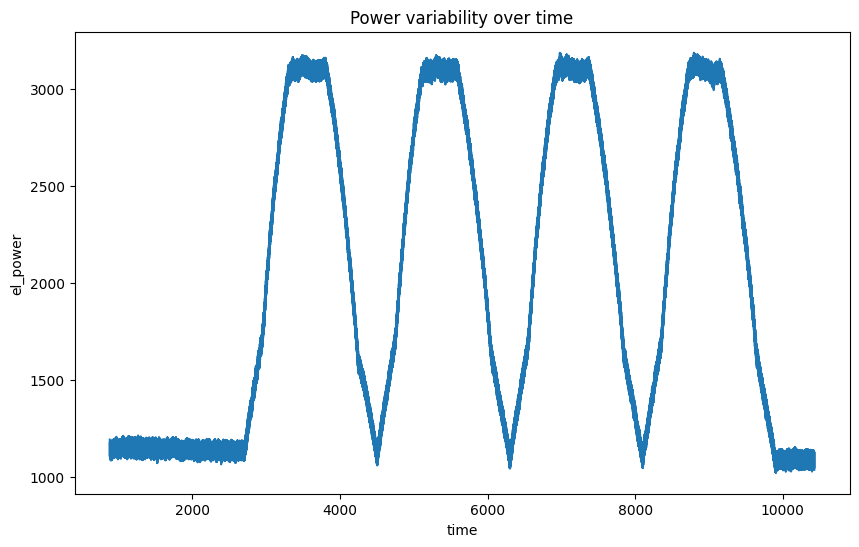

In [53]:
line_plot(test22)

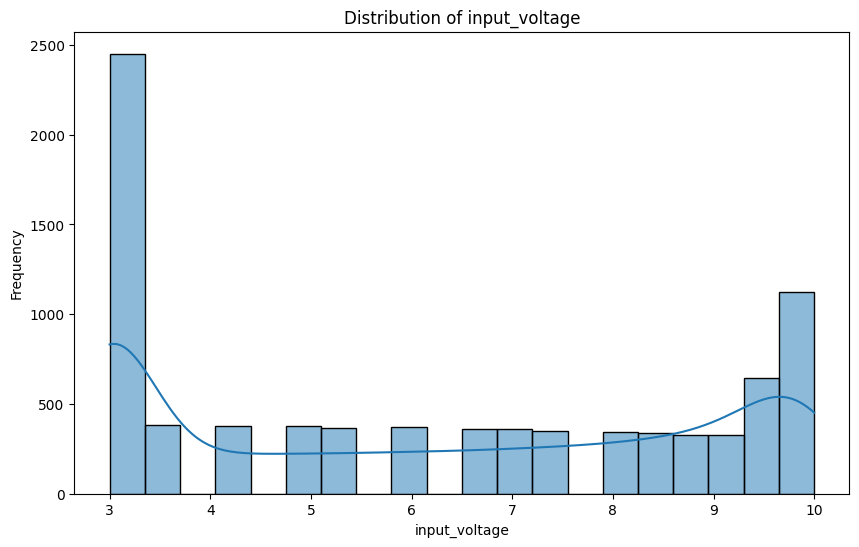

In [54]:
plot_hist(test22, "input_voltage")

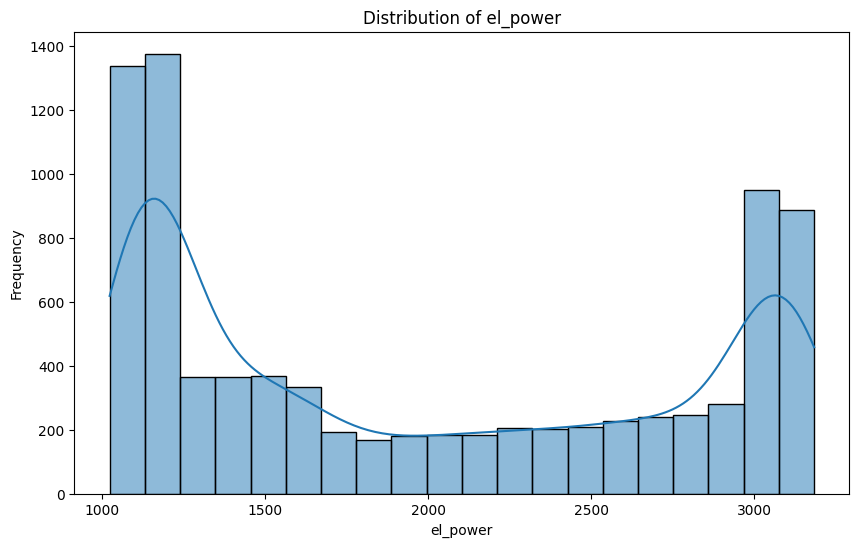

In [55]:
plot_hist(test22, "el_power")

In [56]:
Caculate_ADF(test22, "el_power")

ADF Statistic: -3.9657803308975184
p-value: 0.001600685011029706
Critical Values:
   1%, -3.431123933643013
Critical Values:
   5%, -2.861882025734385
Critical Values:
   10%, -2.5669520554126093


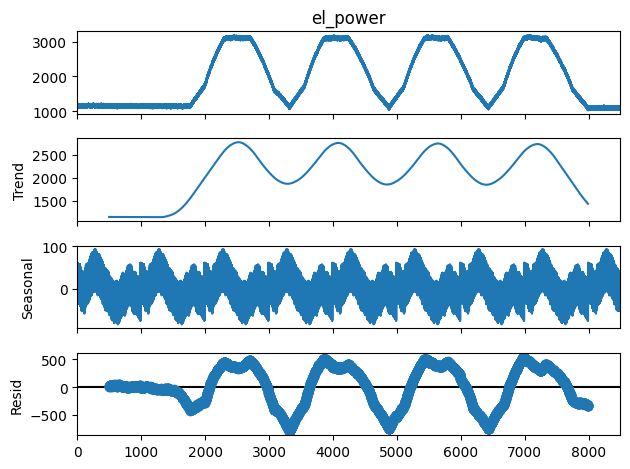

In [57]:
plot_descomposition(test22, "el_power", 1000)

## Implementación SES

In [58]:
train1.index = train1['time']
train1.drop('time', axis=1, inplace=True)

SES_train1 = pd.Series(data=train1['el_power'].values, index=train1.index)

SES_train1

time
810.07028      1228.791720
811.06938      1223.041745
812.06848      1244.960866
813.06758      1229.259058
814.06668      1248.117024
                  ...     
10716.66218     962.030262
10717.66128     963.213626
10718.66038     947.956869
10719.65948     944.314505
10720.65858     968.184917
Length: 9920, dtype: float64

In [59]:
def firstsmooth(y, lambda_, start=None):
    ytilde = y.copy()
    if start is None:
        start = y.iloc[0]  # Acceder al primer valor por posición
    ytilde.iloc[0] = lambda_ * y.iloc[0] + (1 - lambda_) * start  # Usar iloc para acceder al valor
    for i in range(1, len(y)):
        ytilde.iloc[i] = lambda_ * y.iloc[i] + (1 - lambda_) * ytilde.iloc[i - 1]  # Usar iloc para la posición
    return ytilde




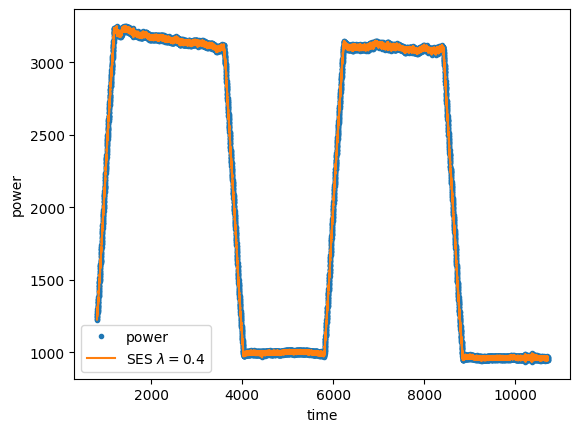

In [60]:
FirstS_SES_train1 = firstsmooth(y=SES_train1, lambda_=0.4)

plt.plot(SES_train1, marker='o', linestyle='', markersize=3, label='power')
plt.plot(SES_train1, label='SES $\lambda=0.4$')
plt.xlabel('time')
plt.ylabel('power')
plt.legend()
plt.show()

In [61]:
def measacc_fs(y, lambda_):
    out = firstsmooth(y, lambda_)
    T = len(y)
    yh = y.copy().values
    out = pd.concat([pd.Series([y.iloc[0]]), out.iloc[:-1]], ignore_index=True).values
    prederr = yh - out
    SSE = sum(prederr**2)
    MAPE = 100 * sum(abs(prederr / yh)) / T
    MAD = sum(abs(prederr)) / T
    MSD = sum(prederr**2) / T
    ret1 = pd.DataFrame({
        "SSE": [SSE],
        "MAPE": [MAPE],
        "MAD": [MAD],
        "MSD": [MSD]
    })
    ret1.reset_index(drop=True, inplace=True)
    return ret1

measacc_fs(SES_train1, 0.4)


,SSE,MAPE,MAD,MSD
0,2.041790e+06,0.741687,12.863716,205.825566


In [62]:
power_smooth1 = firstsmooth(y=SES_train1, lambda_=0.4)


In [63]:
power_smooth2 = firstsmooth(y=power_smooth1, lambda_=0.4)

In [64]:
power_hat = 2 * power_smooth1 - power_smooth2

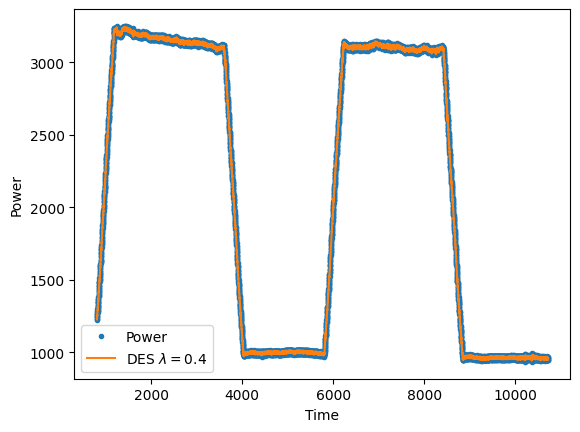

In [65]:
plt.plot(SES_train1, marker='o', linestyle='', markersize=3, label='Power')
plt.plot(power_hat, label='DES $\lambda=0.4$')
plt.xlabel('Time')
plt.ylabel('Power')
plt.legend()
plt.show()

In [66]:
def tlsmooth(y, delta_, y_tilde_start=None, lambda_start=1):
    T = len(y)
    
    Qt = np.zeros(T)
    Dt = np.zeros(T)
    y_tilde = np.zeros(T)
    lambd = np.zeros(T)
    err = np.zeros(T)
    
    lambd[0] = lambda_start
    if y_tilde_start is None:
        y_tilde[0] = y.iloc[0]  # Usar .iloc para acceso posicional
    else:
        y_tilde[0] = y_tilde_start  # Error aquí, debería ser y_tilde[0]
    
    for i in range(1, T):
        err[i] = y.iloc[i] - y_tilde[i-1]  # Usar .iloc para acceder a y
        Qt[i] = delta_ * err[i] + (1 - delta_) * Qt[i-1]
        Dt[i] = delta_ * abs(err[i]) + (1 - delta_) * Dt[i-1]
        lambd[i] = abs(Qt[i] / Dt[i])
        y_tilde[i] = lambd[i] * y.iloc[i] + (1 - lambd[i]) * y_tilde[i-1]  # Usar .iloc en y
    
    return np.column_stack((y_tilde, lambd, err, Qt, Dt))

out_tl_dji = tlsmooth(SES_train1, 0.3)


In [67]:
out_power = tlsmooth(SES_train1, 0.3)

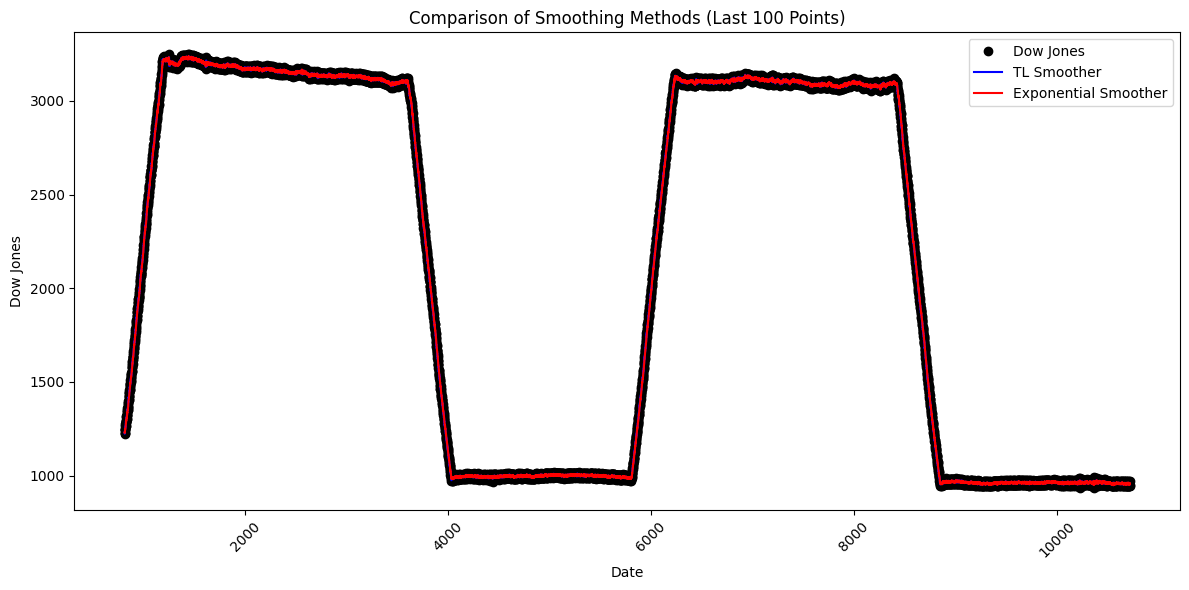

In [69]:
def plot_smoothed_data(SES_train1, out_power, power_smooth1, last_fc=100):
    # Asegurarse de que out_power sea un DataFrame
    if isinstance(out_power, pd.DataFrame):
        tl_smoothed = out_power['y_tilde']
    else:
        tl_smoothed = pd.Series(out_power[:, 0], index=SES_train1.index)
    
    # Asegurarse de que power_smooth1 sea una Serie
    if not isinstance(power_smooth1, pd.Series):
        power_smooth1 = pd.Series(power_smooth1, index=SES_train1.index)
    
    # Tomar los últimos last_fc puntos de todas las series
    SES_last = SES_train1[-last_fc:]
    tl_last = tl_smoothed[-last_fc:]
    exp_last = power_smooth1[-last_fc:]
    
    # Crear el gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(SES_last.index, SES_last, marker='o', linestyle='', color='black', label='Dow Jones')
    plt.plot(tl_last.index, tl_last, color='blue', label='TL Smoother')
    plt.plot(exp_last.index, exp_last, color='red', label='Exponential Smoother')
    
    plt.xlabel('Date')
    plt.ylabel('Dow Jones')
    plt.legend()
    plt.title(f'Comparison of Smoothing Methods (Last {last_fc} Points)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
plot_smoothed_data(SES_train1, out_power, power_smooth1)

In [ ]:
tau_test = 48
tau_val  = 48    

train = y[:-(tau_val + tau_test)].copy()
val   = y[-(tau_val + tau_test):-tau_test].copy()
test  = y[-tau_test:].copy()

print(f"Train: {len(train)}, Validation: {len(val)}, Test: {len(test)}")

In [70]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
def tes_optimizer(train, val, abg, trend, seasonal,  seasonal_periods, step):
    
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(val, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae

    return best_alpha, best_beta, best_gamma, best_mae

In [71]:
def tes_model_tuning(train, val, test, step, trend, seasonal, seasonal_periods, title="Model Tuning - Triple Exponential Smoothing"):
    
    alphas = betas = gammas = np.arange(0.10, 1, 0.10)
    abg = list(itertools.product(alphas, betas, gammas))
    best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, val, abg=abg, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods, step=step)
    
    final_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
    y_pred = final_model.forecast(step + step)[-step:]
    mae = mean_absolute_error(test, y_pred)
    
    plot_model(train, val, test, y_pred, title)
    
    return best_alpha, best_beta, best_gamma, best_mae

In [ ]:
best_alpha, best_beta, best_gamma, best_mae = tes_model_tuning(SES_train1, val, test, step=tau_test, trend='add', seasonal='add', seasonal_periods=12)